In [1]:
import cv2
import keras
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import json

/home/abhijit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(500)

In [3]:
%matplotlib inline

In [4]:
print(cv2.__version__)
print(keras.__version__)
print(np.__version__)

3.4.1
2.2.4
1.14.5


In [5]:
model = keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

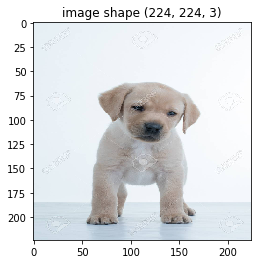

In [7]:
image = np.array(keras.preprocessing.image.load_img(path="./images/labrador.jpeg",target_size=(224,224)))
plt.title("image shape {}".format(image.shape))
plt.imshow(image)
plt.show()

In [8]:
with open("./imagenet_labelmap.json", "r") as f:
    labelmap = json.load(f)

In [9]:
preprocessed_image = keras.applications.vgg16.preprocess_input(image.astype(np.float32))
input_image = np.expand_dims(preprocessed_image, axis=0)  # Needs to be of shape (1, 224, 244, 3)
print(input_image.shape)

(1, 224, 224, 3)


In [10]:
predictions = np.squeeze(model.predict(input_image))
prediction_index = np.argmax(predictions)
prediction_class = labelmap[str(prediction_index)]
prediction_score = predictions[prediction_index]

print("Prediction: {}\nConfidence score: {}".format(prediction_class, prediction_score))

Prediction: Labrador_retriever
Confidence score: 0.8929281234741211


# Generating adversarial-examples
[EXPLAINING AND HARNESSING
ADVERSARIAL EXAMPLES](https://arxiv.org/pdf/1412.6572.pdf):
Let θ be the parameters of a model, x the input to the model, y the targets associated with x (for
machine learning tasks that have targets) and J(θ, x, y) be the cost used to train the neural network.
We can linearize the cost function around the current value of θ, obtaining an optimal max-norm
constrained pertubation of: 

$$ Adversarial \ Noise = epsilon * sign (\frac{\partial J(θ, x, y)}{\partial x})$$
$$ adversarial \ image = Original \ Image + Adversarial \ Noise $$


This is referred to as the **fast gradient sign method** of generating adversarial examples. Note that the required gradient can be computed efficiently using backpropagation.

In [11]:
imagenet_mean = np.array([123.68, 116.779, 103.939], dtype = np.float32)  # BGR
deprocess_image = lambda x: (x[:, :, :, ::-1] + imagenet_mean)

In [12]:
target_idx      = model.predict(input_image).argmax()
target          = keras.utils.np_utils.to_categorical(target_idx, 1000)
target_variable = K.variable(target)
loss            = keras.metrics.categorical_crossentropy(model.output, target_variable)
gradients       = K.gradients(loss, model.input)
get_grad_values = K.function([model.input], gradients)
grad_values     = get_grad_values([input_image])[0]

In [13]:
grad_signs = np.sign(grad_values)

In [14]:
epsilon         = 0.25  # from paper
perturbation    = grad_signs * epsilon
modified_array  = input_image + perturbation
deprocess_array = np.clip(deprocess_image(modified_array), 0., 255.).astype(np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


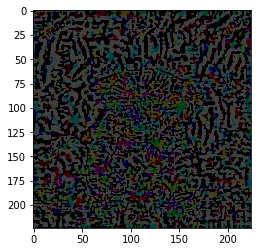

In [15]:
plt.imshow(perturbation[0])
plt.show()

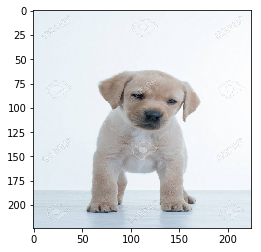

In [16]:
plt.imshow(deprocess_array[0])

In [17]:
pred = np.squeeze(model.predict(deprocess_array))

In [18]:
pred_index = np.argmax(pred)

In [19]:
pred_index

850

In [20]:
labelmap[str(np.argmax(model.predict(deprocess_array)))]

'teddy'

# LOL This is now classifying the image as Teddy even though it visually looks a labrador retriver

In [21]:
pred[pred_index]

0.27484724

In [22]:
pred[208]  # index of labrador_retriver

0.051737063